# Experiment 2: Template Prompt Transfer with Genetic Algorithms

## Goal
Transfer prompt style from a reference image to a target model, evolving structured prompts.

## Methodology
- **Genome**: BlockGenome (subject + composition + lighting + style + quality + negative)
- **Fitness**: w1 * CLIP_score + w2 * LPIPS_similarity (to reference)
- **Reference**: High-quality image whose style/structure we want to replicate
- **Target Model**: qwen-image (Fal AI)
- **LLM Seeding**: Use Gemini to analyze reference and generate initial seeds

## Sub-experiments
- **2.1 Static Weights**: Fixed CLIP=0.5, LPIPS=0.5 throughout evolution
- **2.2 Adaptive Weights**: CLIP weight increases from 0.3 → 0.6 over generations
  - Early: Focus on structure matching (LPIPS)
  - Later: Focus on content alignment (CLIP)

---

## Cell 0: Install Dependencies

Run this cell first to ensure all required packages are installed.

In [3]:
# Install required dependencies for Experiment 2
# LPIPS is required for perceptual similarity scoring

import subprocess
import sys

def install_if_missing(package, pip_name=None):
    """Install package if not already installed."""
    pip_name = pip_name or package
    try:
        __import__(package)
        print(f"✓ {package} is already installed")
    except ImportError:
        print(f"Installing {pip_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name, "-q"])
        print(f"✓ {pip_name} installed successfully")

# Install lpips (Learned Perceptual Image Patch Similarity)
install_if_missing("lpips")

# Other dependencies that should already be installed
install_if_missing("transformers")
install_if_missing("torch")
install_if_missing("torchvision")

print("\nAll dependencies ready!")

Installing lpips...


DEPRECATION: Loading egg at /opt/homebrew/anaconda3/lib/python3.12/site-packages/hubx_ai_lab-0.2.2-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


✓ lpips installed successfully
✓ transformers is already installed
✓ torch is already installed
✓ torchvision is already installed

All dependencies ready!


In [4]:
# Standard library imports
import sys
import os
import json
import random
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Any, Optional

# Add parent directory to path for src imports
sys.path.insert(0, '..')

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import scipy.stats as stats

# Project imports - Block-based genome and evolution (v2)
from src.genome_v2 import BlockGenome, BlockGenomeFactory
from src.evolution_v2 import BlockGeneticOperators, BlockEvolutionEngine
from src.fitness_v2 import TemplateFitnessEvaluator, AdaptiveTemplateFitnessEvaluator
from src.models import get_model
from src.llm_prompt_generator import get_prompt_generator, GeminiPromptGenerator, DummyPromptGenerator
from src.utils import (
    create_block_vocabularies,
    save_json,
    Logger
)

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Configure matplotlib for publication-quality plots
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 11,
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Enable inline plotting
%matplotlib inline

print("Environment setup complete.")
print(f"Random seed: {RANDOM_SEED}")
print(f"Working directory: {os.getcwd()}")

Environment setup complete.
Random seed: 42
Working directory: /Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/experiments


## Cell 2: Configuration

In [5]:
# =============================================================================
# EXPERIMENT PARAMETERS
# =============================================================================

# Subject transfer: User's desired subject (different from reference)
# Reference might show a "camera", we want to generate a "laptop" in same style
USER_SUBJECT = "a professional product photo of a car"

# Evolution parameters
POPULATION_SIZE = 10
MAX_GENERATIONS = 20  # Start small for testing, increase for full experiment
ELITE_SIZE = 1
MUTATION_RATE = 0.4
ADD_PROBABILITY = 0.3
REMOVE_PROBABILITY = 0.2

# Genome constraints
MAX_ITEMS_PER_BLOCK = 3

# =============================================================================
# FITNESS WEIGHTS
# =============================================================================

# Static weights (Experiment 2.1)
STATIC_CLIP_WEIGHT = 0.5   # Content alignment with user subject
STATIC_LPIPS_WEIGHT = 0.5  # Structure similarity to reference

# Adaptive weights (Experiment 2.2)
# Strategy: Start with structure matching, shift to content alignment
INITIAL_CLIP_WEIGHT = 0.3  # Early: prioritize LPIPS (structure)
FINAL_CLIP_WEIGHT = 0.6    # Late: prioritize CLIP (content)

# =============================================================================
# MODEL SETTINGS
# =============================================================================

MODEL_NAME = "qwen-image"  # Supports negative prompts
IMAGE_SIZE = "landscape_4_3"
NUM_INFERENCE_STEPS = 30
GUIDANCE_SCALE = 3.5
GENERATION_SEED = 42  # Fixed seed for reproducible image generation

# =============================================================================
# LLM SETTINGS
# =============================================================================

USE_LLM_SEEDING = True  # Set to False to use random seeding (no Gemini required)

# =============================================================================
# OUTPUT SETTINGS
# =============================================================================

OUTPUT_DIR = Path("../data/results/experiment_2")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
SAVE_EVERY_N_GENERATIONS = 5  # Save checkpoints every N generations

# Print configuration summary
print("=" * 60)
print("EXPERIMENT 2 CONFIGURATION")
print("=" * 60)
print(f"\nUser Subject: {USER_SUBJECT}")
print(f"\nEvolution Parameters:")
print(f"  Population Size: {POPULATION_SIZE}")
print(f"  Max Generations: {MAX_GENERATIONS}")
print(f"  Elite Size: {ELITE_SIZE}")
print(f"  Mutation Rate: {MUTATION_RATE}")
print(f"  Max Items per Block: {MAX_ITEMS_PER_BLOCK}")
print(f"\nStatic Weights (Exp 2.1):")
print(f"  CLIP: {STATIC_CLIP_WEIGHT}, LPIPS: {STATIC_LPIPS_WEIGHT}")
print(f"\nAdaptive Weights (Exp 2.2):")
print(f"  CLIP: {INITIAL_CLIP_WEIGHT} -> {FINAL_CLIP_WEIGHT}")
print(f"\nModel: {MODEL_NAME}")
print(f"LLM Seeding: {'Enabled (Gemini)' if USE_LLM_SEEDING else 'Disabled (Random)'}")
print(f"Output Directory: {OUTPUT_DIR}")
print("=" * 60)

EXPERIMENT 2 CONFIGURATION

User Subject: a professional product photo of a car

Evolution Parameters:
  Population Size: 10
  Max Generations: 20
  Elite Size: 1
  Mutation Rate: 0.4
  Max Items per Block: 3

Static Weights (Exp 2.1):
  CLIP: 0.5, LPIPS: 0.5

Adaptive Weights (Exp 2.2):
  CLIP: 0.3 -> 0.6

Model: qwen-image
LLM Seeding: Enabled (Gemini)
Output Directory: ../data/results/experiment_2


## Cell 3: Load Reference Image

Generating reference image using flux-schnell...
Reference prompt: Professional product photo of a car on a showroom floor, bright studio lighting with soft shadows, clean white background, ultra‑realistic, sharp focus, high detail, minimal reflections
Reference image saved to: ../data/results/experiment_2/reference_image.jpg


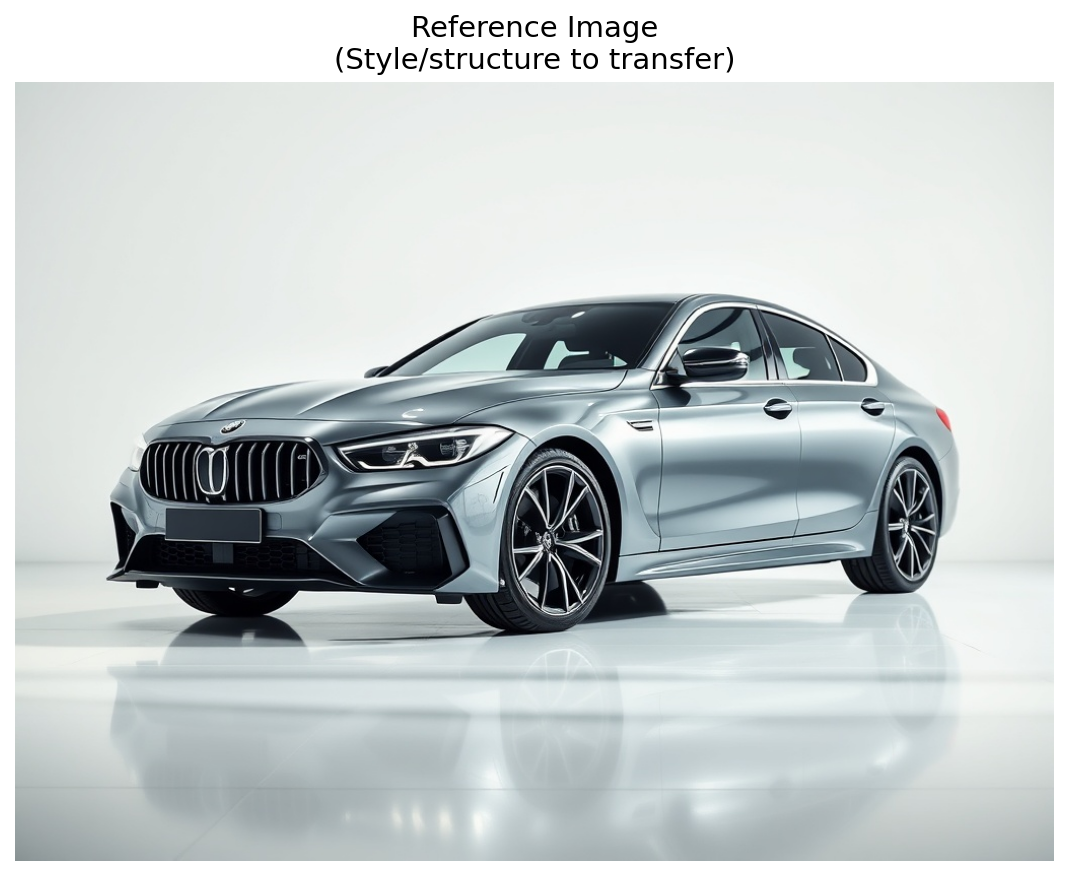


Reference image size: (1024, 768)
Target subject: a professional product photo of a car

Goal: Generate images of the target subject with the style/structure of the reference.


In [9]:
# =============================================================================
# LOAD REFERENCE IMAGE
# =============================================================================
# The reference image defines the style/structure we want to transfer
# to our target subject (USER_SUBJECT)

# Option 1: Load from file
REFERENCE_IMAGE_PATH = "../data/reference_images/product_reference.jpg"

# Option 2: Generate a reference image using flux-schnell
GENERATE_REFERENCE = True  # Set to False to load from file
REFERENCE_PROMPT = "Professional product photo of a car on a showroom floor, bright studio lighting with soft shadows, clean white background, ultra‑realistic, sharp focus, high detail, minimal reflections"

if GENERATE_REFERENCE:
    print("Generating reference image using flux-schnell...")
    print(f"Reference prompt: {REFERENCE_PROMPT}")
    
    # Use flux-schnell for reference generation
    reference_model = get_model("flux-schnell")
    
    reference_image, ref_metadata = reference_model.generate(
        prompt=REFERENCE_PROMPT,
        image_size=IMAGE_SIZE,
        num_inference_steps=4,
        seed=GENERATION_SEED
    )
    
    # Save reference image
    ref_save_path = OUTPUT_DIR / "reference_image.jpg"
    reference_image.save(ref_save_path)
    print(f"Reference image saved to: {ref_save_path}")
    
else:
    print(f"Loading reference image from: {REFERENCE_IMAGE_PATH}")
    if not Path(REFERENCE_IMAGE_PATH).exists():
        raise FileNotFoundError(f"Reference image not found: {REFERENCE_IMAGE_PATH}")
    reference_image = Image.open(REFERENCE_IMAGE_PATH).convert('RGB')
    print(f"Reference image loaded: {reference_image.size}")

# Display reference image
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(reference_image)
ax.set_title(f"Reference Image\n(Style/structure to transfer)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "reference_display.png")
plt.show()

print(f"\nReference image size: {reference_image.size}")
print(f"Target subject: {USER_SUBJECT}")
print("\nGoal: Generate images of the target subject with the style/structure of the reference.")

## Cell 4: Initialize Components

In [10]:
# =============================================================================
# INITIALIZE IMAGE GENERATION MODEL
# =============================================================================
print("Initializing image generation model...")
model = get_model(MODEL_NAME)
print(f"  Model: {MODEL_NAME} initialized")

# =============================================================================
# CREATE BLOCK VOCABULARIES
# =============================================================================
print("\nCreating block vocabularies...")
block_vocabularies = create_block_vocabularies()

for block_name, vocab in block_vocabularies.items():
    print(f"  {block_name}: {len(vocab)} terms")

# =============================================================================
# INITIALIZE LLM PROMPT GENERATOR
# =============================================================================
print("\nInitializing prompt generator...")
prompt_generator = get_prompt_generator(use_llm=USE_LLM_SEEDING)

# =============================================================================
# GENERATE LLM SEEDS (if enabled)
# =============================================================================
print("\nGenerating LLM seeds from reference image...")
llm_seeds = prompt_generator.generate_seed_prompts(
    reference=reference_image,
    user_subject=USER_SUBJECT,
    population_size=POPULATION_SIZE
)

print(f"Generated {len(llm_seeds)} seed prompts")
print("\nSample seed prompt:")
if llm_seeds:
    sample_seed = llm_seeds[0]
    for block_name, values in sample_seed.items():
        print(f"  {block_name}: {values}")

# =============================================================================
# CREATE GENOME FACTORY
# =============================================================================
print("\nCreating block genome factory...")
factory = BlockGenomeFactory(
    block_vocabularies=block_vocabularies,
    max_per_block=MAX_ITEMS_PER_BLOCK
)
print(f"  Max items per block: {MAX_ITEMS_PER_BLOCK}")

# =============================================================================
# CREATE GENETIC OPERATORS
# =============================================================================
print("\nCreating genetic operators...")
operators = BlockGeneticOperators(
    factory=factory,
    mutation_rate=MUTATION_RATE,
    add_probability=ADD_PROBABILITY,
    remove_probability=REMOVE_PROBABILITY
)
print(f"  Mutation rate: {MUTATION_RATE}")

# =============================================================================
# CREATE EVOLUTION ENGINE
# =============================================================================
print("\nCreating evolution engine...")
engine = BlockEvolutionEngine(
    factory=factory,
    operators=operators,
    population_size=POPULATION_SIZE,
    elite_size=ELITE_SIZE,
    selection_method="tournament",
    use_crossover=True  # Enable block crossover
)
print(f"  Population size: {POPULATION_SIZE}")
print(f"  Elite size: {ELITE_SIZE}")
print(f"  Crossover: Enabled")

# =============================================================================
# CREATE FITNESS EVALUATORS
# =============================================================================
print("\nCreating fitness evaluators...")

# Static fitness evaluator (Experiment 2.1)
static_evaluator = TemplateFitnessEvaluator(
    reference_image=reference_image,
    clip_weight=STATIC_CLIP_WEIGHT,
    lpips_weight=STATIC_LPIPS_WEIGHT
)
print(f"  Static Evaluator: CLIP={STATIC_CLIP_WEIGHT}, LPIPS={STATIC_LPIPS_WEIGHT}")

# Adaptive fitness evaluator (Experiment 2.2)
adaptive_evaluator = AdaptiveTemplateFitnessEvaluator(
    reference_image=reference_image,
    initial_clip_weight=INITIAL_CLIP_WEIGHT,
    final_clip_weight=FINAL_CLIP_WEIGHT,
    max_generations=MAX_GENERATIONS
)
print(f"  Adaptive Evaluator: CLIP {INITIAL_CLIP_WEIGHT} -> {FINAL_CLIP_WEIGHT}")

# =============================================================================
# INITIALIZE LOGGER
# =============================================================================
logger = Logger(log_dir=str(OUTPUT_DIR / "logs"), name="experiment_2")
logger.info("Experiment 2 components initialized")

print("\n" + "=" * 60)
print("ALL COMPONENTS INITIALIZED SUCCESSFULLY")
print("=" * 60)

Initializing image generation model...
  Model: qwen-image initialized

Creating block vocabularies...
  composition: 18 terms
  lighting: 21 terms
  style: 21 terms
  quality: 14 terms
  negative: 24 terms

Initializing prompt generator...
Initialized Gemini (gemini-2.0-flash-exp) on project hubx-ml-playground

Generating LLM seeds from reference image...
Generated 10 seed prompts

Sample seed prompt:
  composition: ['wide angle', 'centered', 'studio shot']
  lighting: ['soft light', 'even illumination', 'reflective surface']
  style: ['photorealistic', 'clean', 'high-key']
  quality: ['8k', 'detailed', 'professional product photography']
  negative: ['blurry', 'distorted', 'grainy']

Creating block genome factory...
  Max items per block: 3

Creating genetic operators...
  Mutation rate: 0.4

Creating evolution engine...
  Population size: 10
  Elite size: 1
  Crossover: Enabled

Creating fitness evaluators...
Initializing models on cpu...
CLIP model loaded
Setting up [LPIPS] percept

/opt/homebrew/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /opt/homebrew/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth
LPIPS model loaded
Reference image preprocessed
  Static Evaluator: CLIP=0.5, LPIPS=0.5
Initializing models on cpu...
CLIP model loaded
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


2025-12-30 14:06:40,342 - experiment_2 - INFO - Experiment 2 components initialized


Loading model from: /opt/homebrew/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth
LPIPS model loaded
Reference image preprocessed
  Adaptive Evaluator: CLIP 0.3 -> 0.6

ALL COMPONENTS INITIALIZED SUCCESSFULLY


## Cell 5: Baseline Evaluation

Generating baseline image (subject only, no modifiers)...
Subject: a professional product photo of a car

Baseline genome:
  Prompt: a professional product photo of a car
  Negative: (none)

Baseline image generated successfully.

Evaluating baseline fitness...
CLIP score (content): 0.6292
LPIPS similarity (structure): 0.6308
Weighted fitness: 0.6300

Baseline Fitness Score: 0.6300
Baseline image saved to: ../data/results/experiment_2/baseline_image.jpg


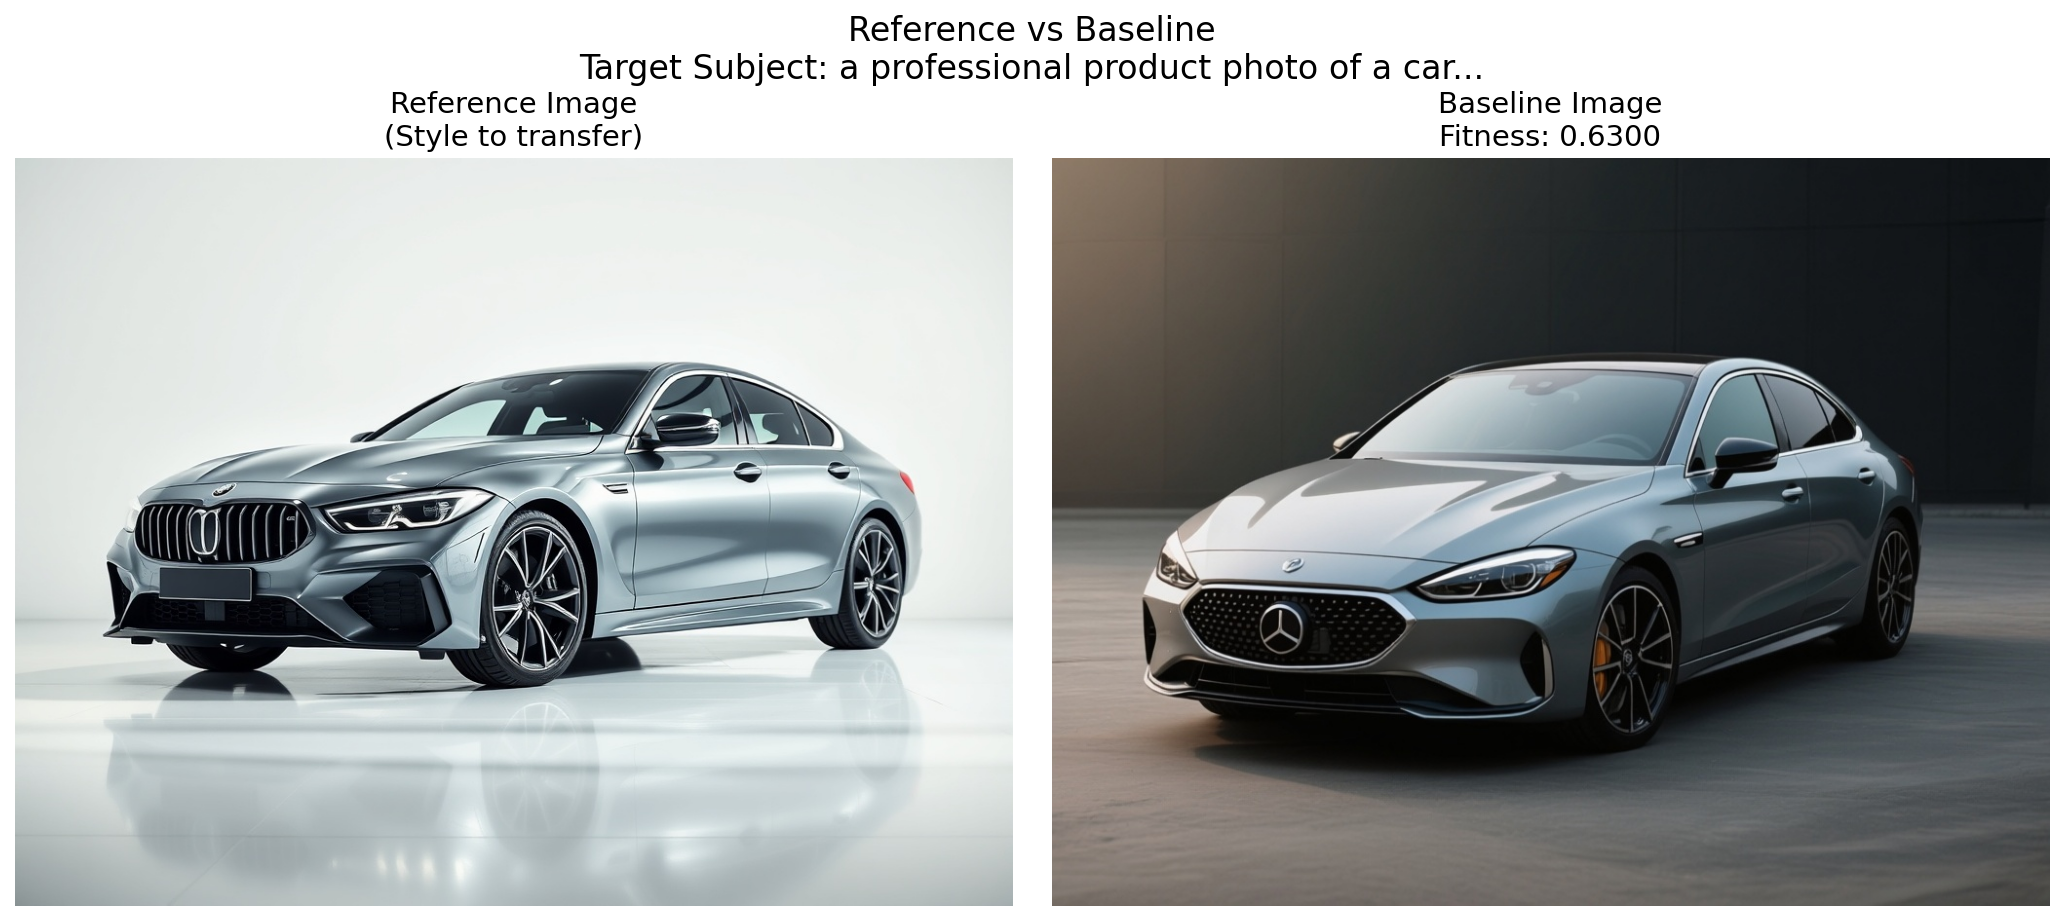

2025-12-30 14:06:56,279 - experiment_2 - INFO - Baseline evaluation complete. Score: 0.6300


In [11]:
# =============================================================================
# GENERATE AND EVALUATE BASELINE
# =============================================================================
# Baseline: Just the subject, no style modifiers

print("Generating baseline image (subject only, no modifiers)...")
print(f"Subject: {USER_SUBJECT}")
print()

# Create baseline genome (empty blocks)
baseline_genome = factory.create_empty(USER_SUBJECT)
print(f"Baseline genome:")
print(f"  Prompt: {baseline_genome.to_prompt()}")
print(f"  Negative: {baseline_genome.get_negative_prompt() or '(none)'}")

# Generate baseline image
try:
    baseline_image, baseline_metadata = model.generate(
        prompt=baseline_genome.to_prompt(),
        negative_prompt=baseline_genome.get_negative_prompt() or None,
        image_size=IMAGE_SIZE,
        num_inference_steps=NUM_INFERENCE_STEPS,
        guidance_scale=GUIDANCE_SCALE,
        seed=GENERATION_SEED
    )
    print("\nBaseline image generated successfully.")
except Exception as e:
    print(f"Error generating baseline image: {e}")
    raise

# Evaluate baseline fitness using static evaluator
print("\nEvaluating baseline fitness...")
baseline_score = static_evaluator.evaluate(
    image=baseline_image,
    text=USER_SUBJECT,
    verbose=True
)
print(f"\nBaseline Fitness Score: {baseline_score:.4f}")

# Save baseline image
baseline_path = OUTPUT_DIR / "baseline_image.jpg"
baseline_image.save(baseline_path)
print(f"Baseline image saved to: {baseline_path}")

# Display comparison: Reference vs Baseline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(reference_image)
axes[0].set_title("Reference Image\n(Style to transfer)", fontsize=14)
axes[0].axis('off')

axes[1].imshow(baseline_image)
axes[1].set_title(f"Baseline Image\nFitness: {baseline_score:.4f}", fontsize=14)
axes[1].axis('off')

plt.suptitle(f"Reference vs Baseline\nTarget Subject: {USER_SUBJECT[:50]}...", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "reference_vs_baseline.png", bbox_inches='tight')
plt.show()

# Log baseline results
logger.info(f"Baseline evaluation complete. Score: {baseline_score:.4f}")

## Cell 6: Helper Functions

In [12]:
def run_experiment(
    evaluator: TemplateFitnessEvaluator,
    experiment_name: str,
    llm_seeds: List[Dict[str, List[str]]],
    max_generations: int = MAX_GENERATIONS,
    save_every: int = SAVE_EVERY_N_GENERATIONS,
    is_adaptive: bool = False
) -> Tuple[Dict[str, Any], List[BlockGenome]]:
    """
    Run one complete evolutionary experiment for template transfer.
    
    Args:
        evaluator: Fitness evaluator (static or adaptive)
        experiment_name: Name for saving results
        llm_seeds: LLM-generated seed prompts for initialization
        max_generations: Maximum number of generations
        save_every: Save checkpoint every N generations
        is_adaptive: Whether using adaptive evaluator
    
    Returns:
        history: Dict with fitness tracking per generation
        final_population: Final evolved population
    """
    # Create experiment output directory
    exp_dir = OUTPUT_DIR / experiment_name
    exp_dir.mkdir(parents=True, exist_ok=True)
    
    # Initialize tracking
    history = {
        'best_fitness': [],
        'avg_fitness': [],
        'worst_fitness': [],
        'diversity': [],
        'best_prompts': [],
        'clip_weights': [],
        'lpips_weights': [],
        'block_diversity': []  # Per-block diversity tracking
    }
    
    # Initialize population with LLM seeds
    print(f"Initializing population with LLM seeds...")
    population = engine.initialize_population(USER_SUBJECT, llm_seeds=llm_seeds)
    print(f"Population size: {len(population)}")
    
    # Evolution loop
    for generation in range(max_generations):
        print(f"\n--- Generation {generation + 1}/{max_generations} ---")
        
        # Update adaptive weights if using adaptive evaluator
        if is_adaptive:
            evaluator.update_generation(generation)
            current_clip_weight = evaluator.clip_weight
            current_lpips_weight = evaluator.lpips_weight
        else:
            current_clip_weight = STATIC_CLIP_WEIGHT
            current_lpips_weight = STATIC_LPIPS_WEIGHT
        
        history['clip_weights'].append(current_clip_weight)
        history['lpips_weights'].append(current_lpips_weight)
        
        print(f"Weights: CLIP={current_clip_weight:.2f}, LPIPS={current_lpips_weight:.2f}")
        
        # Evaluate fitness for all genomes
        gen_images = []
        for idx, genome in enumerate(tqdm(population, desc="Evaluating population")):
            try:
                # Generate image with negative prompt support
                image, metadata = model.generate(
                    prompt=genome.to_prompt(),
                    negative_prompt=genome.get_negative_prompt() or None,
                    image_size=IMAGE_SIZE,
                    num_inference_steps=NUM_INFERENCE_STEPS,
                    guidance_scale=GUIDANCE_SCALE,
                    seed=GENERATION_SEED + generation * 100 + idx
                )
                
                # Evaluate fitness (using subject for CLIP)
                genome.fitness = evaluator.evaluate(image, USER_SUBJECT)
                gen_images.append((genome.fitness, image, genome.to_prompt()))
                
            except Exception as e:
                print(f"Error evaluating genome {idx}: {e}")
                genome.fitness = 0.0
        
        # Track fitness statistics
        fitnesses = [g.fitness for g in population]
        best_fitness = max(fitnesses)
        avg_fitness = np.mean(fitnesses)
        worst_fitness = min(fitnesses)
        
        # Get block-wise diversity
        diversity_dict = engine.get_diversity(population)
        overall_diversity = np.mean(list(diversity_dict.values()))
        
        history['best_fitness'].append(best_fitness)
        history['avg_fitness'].append(avg_fitness)
        history['worst_fitness'].append(worst_fitness)
        history['diversity'].append(overall_diversity)
        history['block_diversity'].append(diversity_dict)
        
        # Get best genome
        best_genome = engine.get_best(population)
        history['best_prompts'].append(best_genome.to_prompt())
        
        print(f"Best: {best_fitness:.4f} | Avg: {avg_fitness:.4f} | Diversity: {overall_diversity:.2f}")
        print(f"Best prompt: {best_genome.to_prompt()[:80]}...")
        
        # Save checkpoint
        if (generation + 1) % save_every == 0 or generation == max_generations - 1:
            checkpoint_dir = exp_dir / f"gen_{generation + 1:02d}"
            checkpoint_dir.mkdir(parents=True, exist_ok=True)
            
            # Save best image
            if gen_images:
                gen_images.sort(key=lambda x: x[0], reverse=True)
                best_img = gen_images[0][1]
                best_img.save(checkpoint_dir / "best_image.jpg")
            
            # Save checkpoint data
            checkpoint_data = {
                'generation': generation + 1,
                'best_fitness': best_fitness,
                'avg_fitness': avg_fitness,
                'best_prompt': best_genome.to_prompt(),
                'best_negative': best_genome.get_negative_prompt(),
                'blocks': {
                    'composition': best_genome.composition,
                    'lighting': best_genome.lighting,
                    'style': best_genome.style,
                    'quality': best_genome.quality,
                    'negative': best_genome.negative
                }
            }
            save_json(checkpoint_data, str(checkpoint_dir / "checkpoint.json"))
            print(f"Checkpoint saved to {checkpoint_dir}")
        
        # Evolve to next generation (except on last generation)
        if generation < max_generations - 1:
            population = engine.evolve_generation(population)
    
    # Save final results
    final_results = {
        'experiment_name': experiment_name,
        'generations': max_generations,
        'final_best_fitness': history['best_fitness'][-1],
        'final_avg_fitness': history['avg_fitness'][-1],
        'history': {
            'best_fitness': history['best_fitness'],
            'avg_fitness': history['avg_fitness'],
            'worst_fitness': history['worst_fitness'],
            'diversity': history['diversity'],
            'clip_weights': history['clip_weights'],
            'lpips_weights': history['lpips_weights']
        }
    }
    save_json(final_results, str(exp_dir / "final_results.json"))
    
    logger.info(f"{experiment_name} complete. Best fitness: {history['best_fitness'][-1]:.4f}")
    
    return history, population


def visualize_results(history: Dict[str, List], baseline_score: float, title: str = "Evolution Progress"):
    """
    Create publication-quality convergence plot.
    """
    generations = range(1, len(history['best_fitness']) + 1)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot fitness curves
    ax.plot(generations, history['best_fitness'], 'g-', linewidth=2, 
            label='Best Fitness', marker='o', markersize=4)
    ax.plot(generations, history['avg_fitness'], 'b--', linewidth=1.5,
            label='Average Fitness', alpha=0.8)
    ax.fill_between(generations, history['worst_fitness'], history['best_fitness'],
                    alpha=0.2, color='green', label='Fitness Range')
    
    # Baseline reference line
    ax.axhline(y=baseline_score, color='orange', linestyle='-.', 
               linewidth=2, label=f'Baseline ({baseline_score:.4f})')
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness Score')
    ax.set_title(title)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(1, len(generations))
    
    y_min = min(min(history['worst_fitness']), baseline_score) * 0.95
    y_max = max(history['best_fitness']) * 1.05
    ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    return fig


def compare_experiments(
    exp1_history: Dict[str, List],
    exp2_history: Dict[str, List],
    baseline_score: float,
    exp1_name: str = "Static Weights",
    exp2_name: str = "Adaptive Weights"
):
    """
    Create side-by-side comparison plot for two experiments.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    generations = range(1, len(exp1_history['best_fitness']) + 1)
    
    # Left plot: Fitness comparison
    ax1 = axes[0]
    ax1.plot(generations, exp1_history['best_fitness'], 'b-', linewidth=2,
             label=f'{exp1_name} (Best)', marker='o', markersize=4)
    ax1.plot(generations, exp2_history['best_fitness'], 'r-', linewidth=2,
             label=f'{exp2_name} (Best)', marker='s', markersize=4)
    ax1.axhline(y=baseline_score, color='orange', linestyle='-.', 
                linewidth=2, label=f'Baseline ({baseline_score:.4f})')
    
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Fitness Score')
    ax1.set_title('Best Fitness Comparison')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # Right plot: Weight evolution
    ax2 = axes[1]
    ax2.plot(generations, exp1_history['clip_weights'], 'b--', linewidth=2,
             label=f'{exp1_name} CLIP Weight')
    ax2.plot(generations, exp2_history['clip_weights'], 'r-', linewidth=2,
             label=f'{exp2_name} CLIP Weight')
    ax2.plot(generations, exp2_history['lpips_weights'], 'r:', linewidth=2,
             label=f'{exp2_name} LPIPS Weight')
    
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Weight Value')
    ax2.set_title('Fitness Weight Evolution')
    ax2.legend(loc='center right')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    return fig


def generate_final_image(genome: BlockGenome, seed: int = GENERATION_SEED) -> Tuple[Image.Image, float]:
    """
    Generate final image for a genome with consistent seed.
    """
    image, _ = model.generate(
        prompt=genome.to_prompt(),
        negative_prompt=genome.get_negative_prompt() or None,
        image_size=IMAGE_SIZE,
        num_inference_steps=NUM_INFERENCE_STEPS,
        guidance_scale=GUIDANCE_SCALE,
        seed=seed
    )
    fitness = static_evaluator.evaluate(image, USER_SUBJECT)
    return image, fitness


print("Helper functions defined successfully.")

Helper functions defined successfully.


## Cell 7: Run Experiment 2.1 (Static Weights)

In [13]:
print("=" * 60)
print("EXPERIMENT 2.1: STATIC WEIGHTS")
print(f"CLIP Weight: {STATIC_CLIP_WEIGHT} (fixed)")
print(f"LPIPS Weight: {STATIC_LPIPS_WEIGHT} (fixed)")
print("=" * 60)

# Run experiment with static weights
static_history, static_population = run_experiment(
    evaluator=static_evaluator,
    experiment_name="exp2_1_static",
    llm_seeds=llm_seeds,
    max_generations=MAX_GENERATIONS,
    save_every=SAVE_EVERY_N_GENERATIONS,
    is_adaptive=False
)

# Get best genome from static experiment
best_static_genome = max(static_population, key=lambda g: g.fitness)

print("\n" + "=" * 60)
print("EXPERIMENT 2.1 RESULTS")
print("=" * 60)
print(f"Final Best Fitness: {best_static_genome.fitness:.4f}")
print(f"Improvement over baseline: {(best_static_genome.fitness - baseline_score) / baseline_score * 100:.2f}%")
print(f"\nBest Prompt:")
print(f"  {best_static_genome.to_prompt()}")
print(f"\nNegative Prompt:")
print(f"  {best_static_genome.get_negative_prompt()}")
print(f"\nBlock Breakdown:")
print(f"  Composition: {best_static_genome.composition}")
print(f"  Lighting: {best_static_genome.lighting}")
print(f"  Style: {best_static_genome.style}")
print(f"  Quality: {best_static_genome.quality}")
print(f"  Negative: {best_static_genome.negative}")

EXPERIMENT 2.1: STATIC WEIGHTS
CLIP Weight: 0.5 (fixed)
LPIPS Weight: 0.5 (fixed)
Initializing population with LLM seeds...
Population size: 10

--- Generation 1/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Best: 0.6413 | Avg: 0.6311 | Diversity: 0.77
Best prompt: a professional product photo of a car, wide angle, medium shot, studio shot, sof...

--- Generation 2/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6428 | Avg: 0.6188 | Diversity: 0.85
Best prompt: a professional product photo of a car, wide angle, medium shot, studio shot, sof...

--- Generation 3/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6388 | Avg: 0.6219 | Diversity: 0.70
Best prompt: a professional product photo of a car, wide angle, medium shot, studio shot, sof...

--- Generation 4/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6489 | Avg: 0.6260 | Diversity: 0.63
Best prompt: a professional product photo of a car, wide angle, medium shot, studio shot, sof...

--- Generation 5/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6489 | Avg: 0.6218 | Diversity: 0.67
Best prompt: a professional product photo of a car, wide angle, medium shot, studio shot, sof...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_05

--- Generation 6/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6376 | Avg: 0.6201 | Diversity: 0.60
Best prompt: a professional product photo of a car, wide angle, medium shot, studio shot, sof...

--- Generation 7/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6530 | Avg: 0.6244 | Diversity: 0.65
Best prompt: a professional product photo of a car, wide angle, medium shot, studio shot, sof...

--- Generation 8/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6343 | Avg: 0.6211 | Diversity: 0.56
Best prompt: a professional product photo of a car, wide angle, medium shot, studio shot, sof...

--- Generation 9/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6392 | Avg: 0.6237 | Diversity: 0.60
Best prompt: a professional product photo of a car, wide angle, medium shot, studio shot, sof...

--- Generation 10/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6456 | Avg: 0.6237 | Diversity: 0.56
Best prompt: a professional product photo of a car, wide angle, medium shot, studio shot, sof...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_10

--- Generation 11/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6376 | Avg: 0.6257 | Diversity: 0.51
Best prompt: a professional product photo of a car, rule of thirds, medium shot, studio shot,...

--- Generation 12/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6381 | Avg: 0.6200 | Diversity: 0.53
Best prompt: a professional product photo of a car, rule of thirds, medium shot, studio shot,...

--- Generation 13/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6362 | Avg: 0.6227 | Diversity: 0.54
Best prompt: a professional product photo of a car, rule of thirds, medium shot, studio shot,...

--- Generation 14/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6396 | Avg: 0.6196 | Diversity: 0.53
Best prompt: a professional product photo of a car, oil painting, minimalist, maximalist, sha...

--- Generation 15/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6602 | Avg: 0.6258 | Diversity: 0.40
Best prompt: a professional product photo of a car, macro, oil painting, minimalist, sketch, ...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_15

--- Generation 16/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6500 | Avg: 0.6289 | Diversity: 0.31
Best prompt: a professional product photo of a car, macro, panoramic, oil painting, minimalis...

--- Generation 17/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6618 | Avg: 0.6286 | Diversity: 0.51
Best prompt: a professional product photo of a car, macro, panoramic, oil painting, minimalis...

--- Generation 18/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6560 | Avg: 0.6214 | Diversity: 0.57
Best prompt: a professional product photo of a car, macro, panoramic, oil painting, minimalis...

--- Generation 19/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6549 | Avg: 0.6195 | Diversity: 0.49
Best prompt: a professional product photo of a car, macro, panoramic, oil painting, minimalis...

--- Generation 20/20 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

2025-12-30 14:30:32,317 - experiment_2 - INFO - exp2_1_static complete. Best fitness: 0.6343


Best: 0.6343 | Avg: 0.6222 | Diversity: 0.53
Best prompt: a professional product photo of a car, macro, bird's eye view, full body, waterc...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_20

EXPERIMENT 2.1 RESULTS
Final Best Fitness: 0.6343
Improvement over baseline: 0.68%

Best Prompt:
  a professional product photo of a car, macro, bird's eye view, full body, watercolor, minimalist, digital art, masterpiece, best quality, high resolution

Negative Prompt:
  watermark, overexposed

Block Breakdown:
  Composition: ['macro', "bird's eye view", 'full body']
  Lighting: []
  Style: ['watercolor', 'minimalist', 'digital art']
  Quality: ['masterpiece', 'best quality', 'high resolution']
  Negative: ['watermark', 'overexposed']


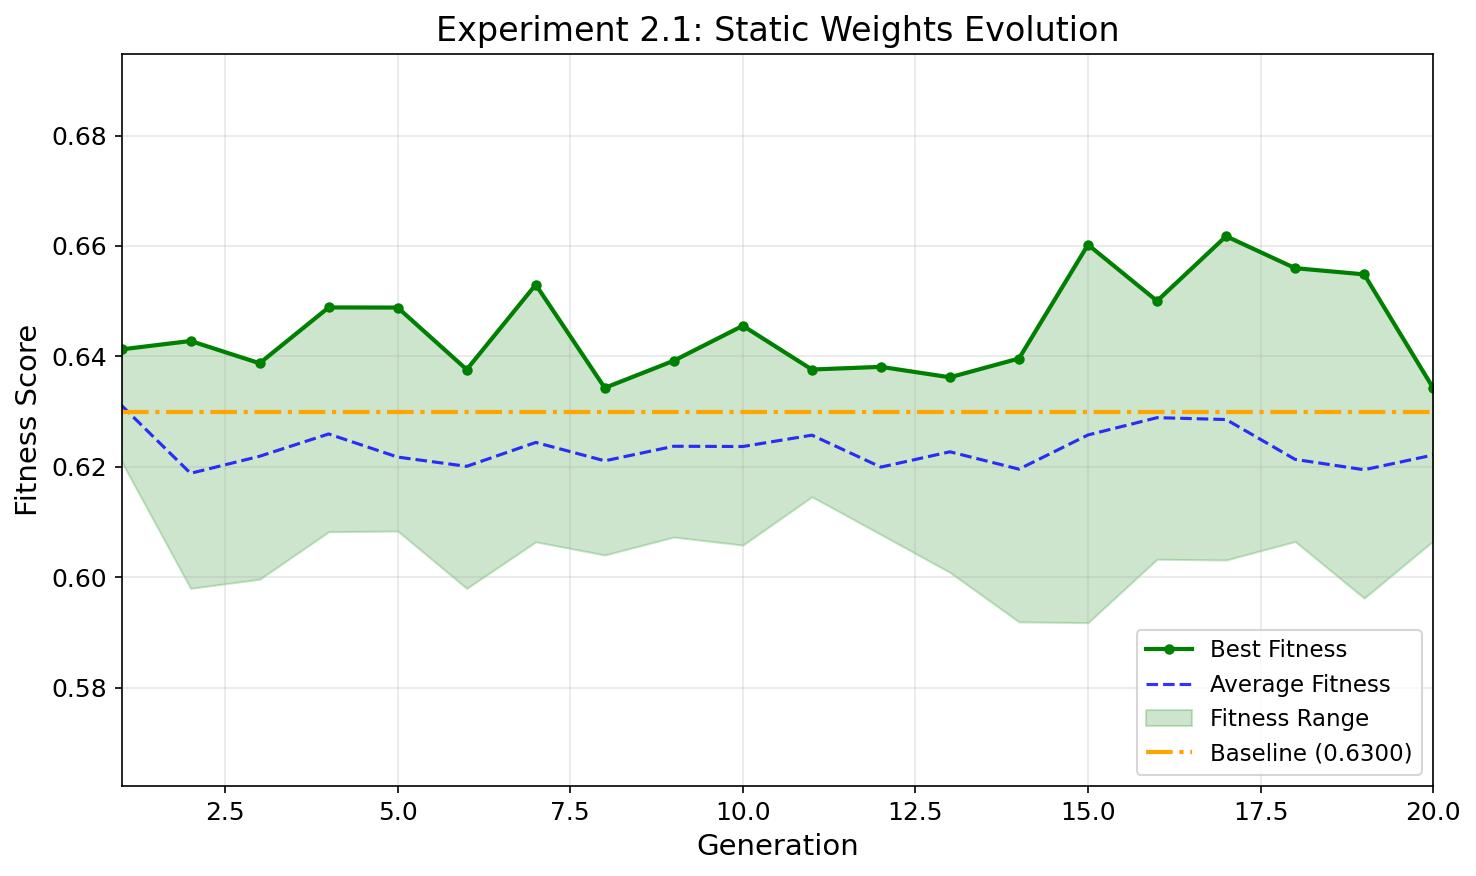

In [14]:
# Visualize static experiment convergence
fig_static = visualize_results(
    static_history, 
    baseline_score,
    title="Experiment 2.1: Static Weights Evolution"
)
fig_static.savefig(OUTPUT_DIR / "exp2_1_convergence.png")
plt.show()

## Cell 8: Run Experiment 2.2 (Adaptive Weights)

In [15]:
print("=" * 60)
print("EXPERIMENT 2.2: ADAPTIVE WEIGHTS")
print(f"CLIP Weight: {INITIAL_CLIP_WEIGHT} -> {FINAL_CLIP_WEIGHT}")
print(f"LPIPS Weight: {1-INITIAL_CLIP_WEIGHT} -> {1-FINAL_CLIP_WEIGHT}")
print("Strategy: Start structure-focused (LPIPS), end content-focused (CLIP)")
print("=" * 60)

# Re-create adaptive evaluator to reset state
adaptive_evaluator = AdaptiveTemplateFitnessEvaluator(
    reference_image=reference_image,
    initial_clip_weight=INITIAL_CLIP_WEIGHT,
    final_clip_weight=FINAL_CLIP_WEIGHT,
    max_generations=MAX_GENERATIONS
)

# Run experiment with adaptive weights
adaptive_history, adaptive_population = run_experiment(
    evaluator=adaptive_evaluator,
    experiment_name="exp2_2_adaptive",
    llm_seeds=llm_seeds,
    max_generations=MAX_GENERATIONS,
    save_every=SAVE_EVERY_N_GENERATIONS,
    is_adaptive=True
)

# Get best genome from adaptive experiment
best_adaptive_genome = max(adaptive_population, key=lambda g: g.fitness)

print("\n" + "=" * 60)
print("EXPERIMENT 2.2 RESULTS")
print("=" * 60)
print(f"Final Best Fitness: {best_adaptive_genome.fitness:.4f}")
print(f"Improvement over baseline: {(best_adaptive_genome.fitness - baseline_score) / baseline_score * 100:.2f}%")
print(f"\nBest Prompt:")
print(f"  {best_adaptive_genome.to_prompt()}")
print(f"\nNegative Prompt:")
print(f"  {best_adaptive_genome.get_negative_prompt()}")
print(f"\nBlock Breakdown:")
print(f"  Composition: {best_adaptive_genome.composition}")
print(f"  Lighting: {best_adaptive_genome.lighting}")
print(f"  Style: {best_adaptive_genome.style}")
print(f"  Quality: {best_adaptive_genome.quality}")
print(f"  Negative: {best_adaptive_genome.negative}")

EXPERIMENT 2.2: ADAPTIVE WEIGHTS
CLIP Weight: 0.3 -> 0.6
LPIPS Weight: 0.7 -> 0.4
Strategy: Start structure-focused (LPIPS), end content-focused (CLIP)
Initializing models on cpu...
CLIP model loaded
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/homebrew/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth
LPIPS model loaded
Reference image preprocessed
Initializing population with LLM seeds...
Population size: 10

--- Generation 1/20 ---
Weights: CLIP=0.30, LPIPS=0.70


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6477 | Avg: 0.6333 | Diversity: 0.77
Best prompt: a professional product photo of a car, wide angle, medium shot, studio shot, sof...

--- Generation 2/20 ---
Weights: CLIP=0.32, LPIPS=0.69


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6519 | Avg: 0.6278 | Diversity: 0.64
Best prompt: a professional product photo of a car, dutch angle, bird's eye view, minimalist ...

--- Generation 3/20 ---
Weights: CLIP=0.33, LPIPS=0.67


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6374 | Avg: 0.6184 | Diversity: 0.65
Best prompt: a professional product photo of a car, dutch angle, bird's eye view, minimalist ...

--- Generation 4/20 ---
Weights: CLIP=0.34, LPIPS=0.66


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6518 | Avg: 0.6210 | Diversity: 0.58
Best prompt: a professional product photo of a car, dutch angle, bird's eye view, minimalist ...

--- Generation 5/20 ---
Weights: CLIP=0.36, LPIPS=0.64


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6388 | Avg: 0.6127 | Diversity: 0.62
Best prompt: a professional product photo of a car, dutch angle, bird's eye view, minimalist ...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_05

--- Generation 6/20 ---
Weights: CLIP=0.38, LPIPS=0.62


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6532 | Avg: 0.6255 | Diversity: 0.62
Best prompt: a professional product photo of a car, dutch angle, asymmetrical, full body, und...

--- Generation 7/20 ---
Weights: CLIP=0.39, LPIPS=0.61


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6382 | Avg: 0.6187 | Diversity: 0.58
Best prompt: a professional product photo of a car, dutch angle, asymmetrical, full body, und...

--- Generation 8/20 ---
Weights: CLIP=0.40, LPIPS=0.59


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6356 | Avg: 0.6195 | Diversity: 0.50
Best prompt: a professional product photo of a car, dutch angle, asymmetrical, full body, und...

--- Generation 9/20 ---
Weights: CLIP=0.42, LPIPS=0.58


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6430 | Avg: 0.6171 | Diversity: 0.51
Best prompt: a professional product photo of a car, dutch angle, asymmetrical, full body, und...

--- Generation 10/20 ---
Weights: CLIP=0.43, LPIPS=0.56


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6366 | Avg: 0.6210 | Diversity: 0.53
Best prompt: a professional product photo of a car, dutch angle, asymmetrical, full body, und...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_10

--- Generation 11/20 ---
Weights: CLIP=0.45, LPIPS=0.55


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6466 | Avg: 0.6252 | Diversity: 0.60
Best prompt: a professional product photo of a car, dutch angle, low angle, diffused lighting...

--- Generation 12/20 ---
Weights: CLIP=0.46, LPIPS=0.54


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6452 | Avg: 0.6226 | Diversity: 0.54
Best prompt: a professional product photo of a car, dutch angle, low angle, diffused lighting...

--- Generation 13/20 ---
Weights: CLIP=0.48, LPIPS=0.52


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6388 | Avg: 0.6180 | Diversity: 0.61
Best prompt: a professional product photo of a car, dutch angle, low angle, diffused lighting...

--- Generation 14/20 ---
Weights: CLIP=0.49, LPIPS=0.51


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6467 | Avg: 0.6197 | Diversity: 0.60
Best prompt: a professional product photo of a car, medium shot, symmetrical, photorealistic,...

--- Generation 15/20 ---
Weights: CLIP=0.51, LPIPS=0.49


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6354 | Avg: 0.6178 | Diversity: 0.55
Best prompt: a professional product photo of a car, medium shot, symmetrical, photorealistic,...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_15

--- Generation 16/20 ---
Weights: CLIP=0.52, LPIPS=0.48


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6424 | Avg: 0.6251 | Diversity: 0.51
Best prompt: a professional product photo of a car, medium shot, symmetrical, rule of thirds,...

--- Generation 17/20 ---
Weights: CLIP=0.54, LPIPS=0.46


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6414 | Avg: 0.6207 | Diversity: 0.52
Best prompt: a professional product photo of a car, medium shot, symmetrical, portrait, photo...

--- Generation 18/20 ---
Weights: CLIP=0.55, LPIPS=0.45


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6485 | Avg: 0.6261 | Diversity: 0.52
Best prompt: a professional product photo of a car, portrait, sketch, oil painting, crystal c...

--- Generation 19/20 ---
Weights: CLIP=0.57, LPIPS=0.43


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.6404 | Avg: 0.6290 | Diversity: 0.40
Best prompt: a professional product photo of a car, portrait, low angle, cinematic, illustrat...

--- Generation 20/20 ---
Weights: CLIP=0.58, LPIPS=0.42


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

2025-12-30 14:53:44,900 - experiment_2 - INFO - exp2_2_adaptive complete. Best fitness: 0.6331


Best: 0.6331 | Avg: 0.6199 | Diversity: 0.43
Best prompt: a professional product photo of a car, full body, photorealistic, oil painting...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_20

EXPERIMENT 2.2 RESULTS
Final Best Fitness: 0.6331
Improvement over baseline: 0.49%

Best Prompt:
  a professional product photo of a car, full body, photorealistic, oil painting

Negative Prompt:
  

Block Breakdown:
  Composition: ['full body']
  Lighting: []
  Style: ['photorealistic', 'oil painting']
  Quality: []
  Negative: []


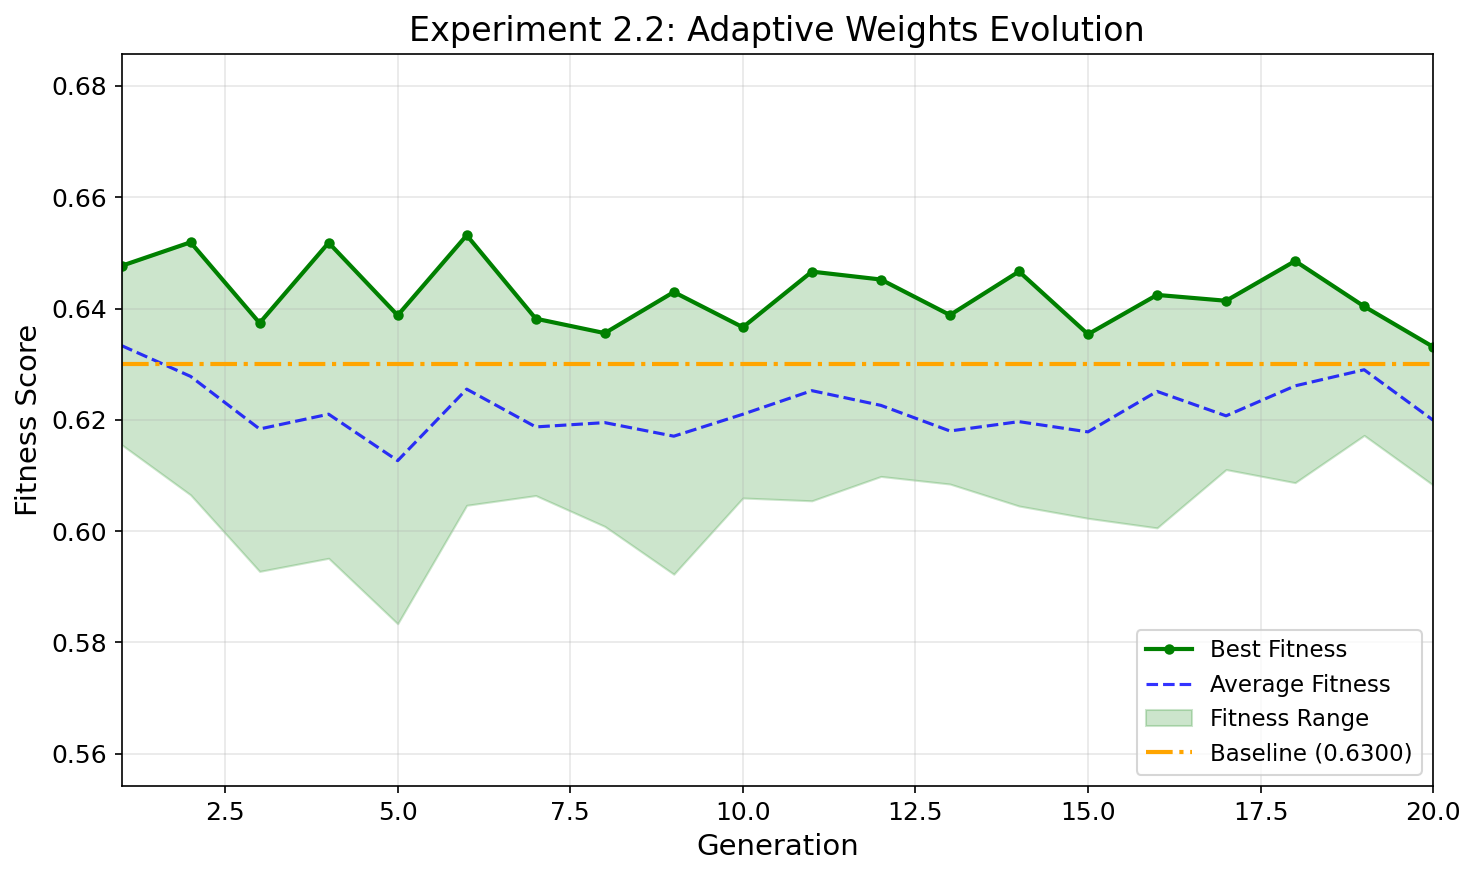

In [16]:
# Visualize adaptive experiment convergence
fig_adaptive = visualize_results(
    adaptive_history, 
    baseline_score,
    title="Experiment 2.2: Adaptive Weights Evolution"
)
fig_adaptive.savefig(OUTPUT_DIR / "exp2_2_convergence.png")
plt.show()

## Cell 9: Comparison & Statistical Analysis

COMPARISON: STATIC vs ADAPTIVE WEIGHTS


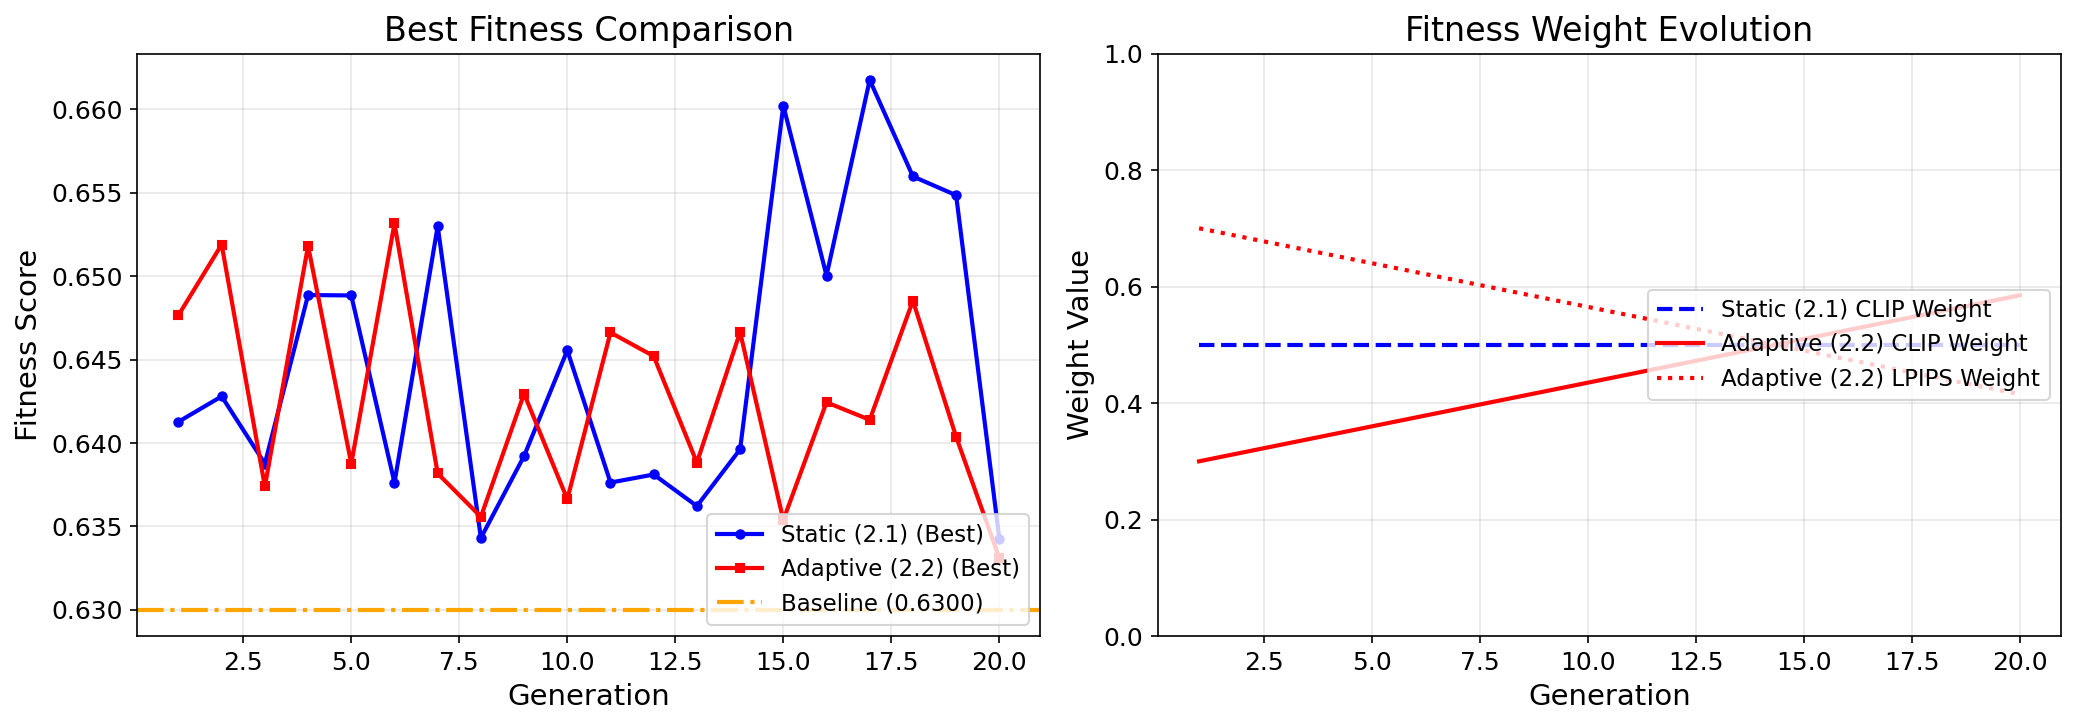


------------------------------------------------------------
STATISTICAL ANALYSIS
------------------------------------------------------------

Independent t-test:
  t-statistic: 0.5475
  p-value: 0.5908
  Significant (p < 0.05): No

Mann-Whitney U test:
  U-statistic: 58.0000
  p-value: 0.5708
  Significant (p < 0.05): No

------------------------------------------------------------
DESCRIPTIVE STATISTICS
------------------------------------------------------------

Baseline:
  Fitness: 0.6300

Static Weights (Exp 2.1):
  Mean:   0.6222
  Std:    0.0094
  Min:    0.6066
  Max:    0.6343
  Median: 0.6224

Adaptive Weights (Exp 2.2):
  Mean:   0.6199
  Std:    0.0078
  Min:    0.6083
  Max:    0.6331
  Median: 0.6190

Effect Size (Cohen's d): -0.2581
  Interpretation: small effect


In [17]:
print("=" * 60)
print("COMPARISON: STATIC vs ADAPTIVE WEIGHTS")
print("=" * 60)

# Side-by-side convergence comparison
fig_comparison = compare_experiments(
    static_history,
    adaptive_history,
    baseline_score,
    exp1_name="Static (2.1)",
    exp2_name="Adaptive (2.2)"
)
fig_comparison.savefig(OUTPUT_DIR / "comparison_plot.png")
plt.show()

# Extract final fitness values for statistical comparison
static_final = [g.fitness for g in static_population]
adaptive_final = [g.fitness for g in adaptive_population]

# Statistical tests
print("\n" + "-" * 60)
print("STATISTICAL ANALYSIS")
print("-" * 60)

# Independent samples t-test
t_stat, p_value = stats.ttest_ind(static_final, adaptive_final)
print(f"\nIndependent t-test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant (p < 0.05): {'Yes' if p_value < 0.05 else 'No'}")

# Mann-Whitney U test (non-parametric alternative)
u_stat, u_pvalue = stats.mannwhitneyu(static_final, adaptive_final, alternative='two-sided')
print(f"\nMann-Whitney U test:")
print(f"  U-statistic: {u_stat:.4f}")
print(f"  p-value: {u_pvalue:.4f}")
print(f"  Significant (p < 0.05): {'Yes' if u_pvalue < 0.05 else 'No'}")

# Descriptive statistics
print("\n" + "-" * 60)
print("DESCRIPTIVE STATISTICS")
print("-" * 60)

print(f"\nBaseline:")
print(f"  Fitness: {baseline_score:.4f}")

print(f"\nStatic Weights (Exp 2.1):")
print(f"  Mean:   {np.mean(static_final):.4f}")
print(f"  Std:    {np.std(static_final):.4f}")
print(f"  Min:    {np.min(static_final):.4f}")
print(f"  Max:    {np.max(static_final):.4f}")
print(f"  Median: {np.median(static_final):.4f}")

print(f"\nAdaptive Weights (Exp 2.2):")
print(f"  Mean:   {np.mean(adaptive_final):.4f}")
print(f"  Std:    {np.std(adaptive_final):.4f}")
print(f"  Min:    {np.min(adaptive_final):.4f}")
print(f"  Max:    {np.max(adaptive_final):.4f}")
print(f"  Median: {np.median(adaptive_final):.4f}")

# Effect size (Cohen's d)
pooled_std = np.sqrt(((len(static_final) - 1) * np.var(static_final) + 
                      (len(adaptive_final) - 1) * np.var(adaptive_final)) / 
                     (len(static_final) + len(adaptive_final) - 2))
cohens_d = (np.mean(adaptive_final) - np.mean(static_final)) / pooled_std if pooled_std > 0 else 0

print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    effect_interpretation = "negligible"
elif abs(cohens_d) < 0.5:
    effect_interpretation = "small"
elif abs(cohens_d) < 0.8:
    effect_interpretation = "medium"
else:
    effect_interpretation = "large"
print(f"  Interpretation: {effect_interpretation} effect")

/var/folders/p7/7kcv3ngd7q18v8lpks6vq25r0000gn/T/ipykernel_31138/3238204588.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=['Static Weights\n(Exp 2.1)', 'Adaptive Weights\n(Exp 2.2)'],


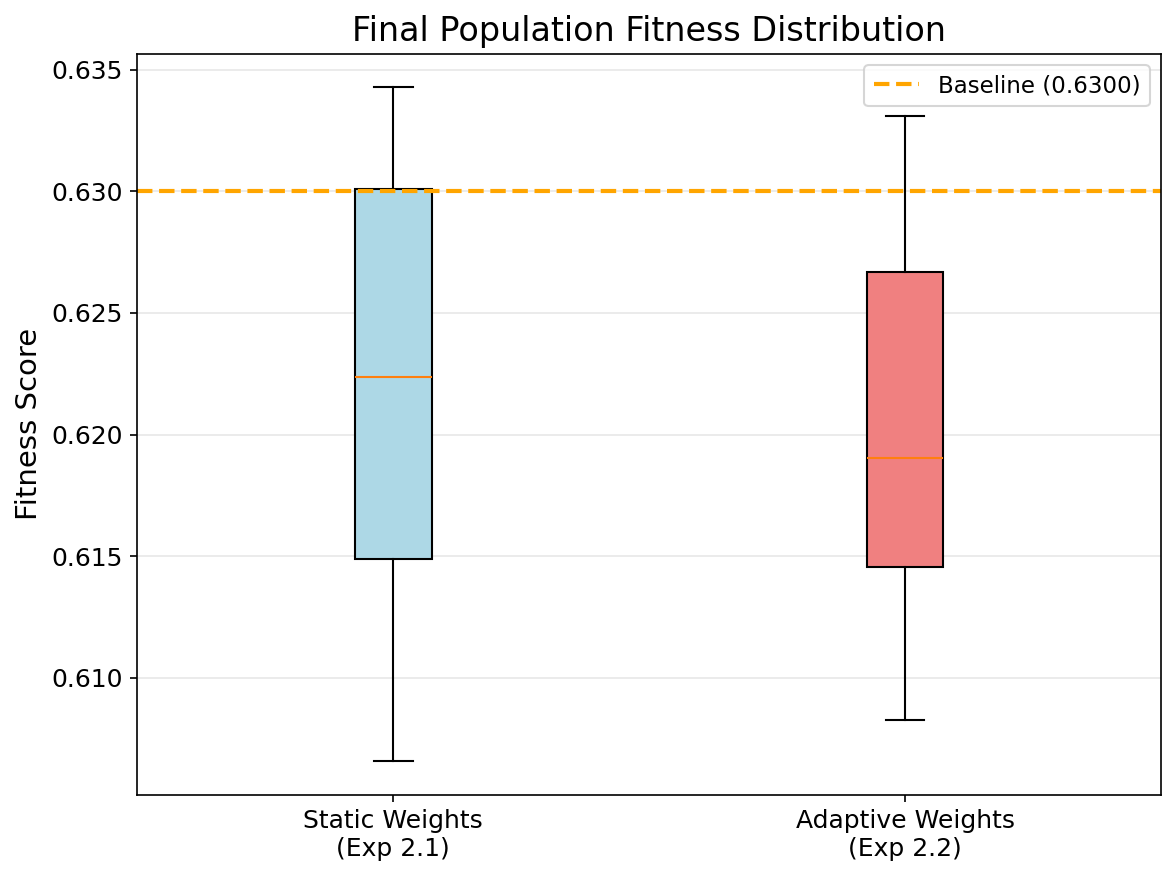

In [18]:
# Box plot comparison
fig, ax = plt.subplots(figsize=(8, 6))

box_data = [static_final, adaptive_final]
bp = ax.boxplot(box_data, labels=['Static Weights\n(Exp 2.1)', 'Adaptive Weights\n(Exp 2.2)'],
                patch_artist=True)

# Color the boxes
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')

# Add baseline line
ax.axhline(y=baseline_score, color='orange', linestyle='--', 
           linewidth=2, label=f'Baseline ({baseline_score:.4f})')

ax.set_ylabel('Fitness Score')
ax.set_title('Final Population Fitness Distribution')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "boxplot_comparison.png")
plt.show()

## Cell 10: Visual Comparison

In [19]:
print("Generating final comparison images...")
print("This may take a moment...\n")

# Generate final images with consistent seed for fair comparison
COMPARISON_SEED = 12345

# Baseline image (regenerate with comparison seed)
print("Generating baseline image...")
baseline_final_image, baseline_final_score = generate_final_image(
    factory.create_empty(USER_SUBJECT), 
    seed=COMPARISON_SEED
)

# Best static image
print("Generating best static weights image...")
static_final_image, static_final_score = generate_final_image(
    best_static_genome, 
    seed=COMPARISON_SEED
)

# Best adaptive image
print("Generating best adaptive weights image...")
adaptive_final_image, adaptive_final_score = generate_final_image(
    best_adaptive_genome, 
    seed=COMPARISON_SEED
)

print("Image generation complete.")

Generating final comparison images...
This may take a moment...

Generating baseline image...
Generating best static weights image...
Generating best adaptive weights image...
Image generation complete.


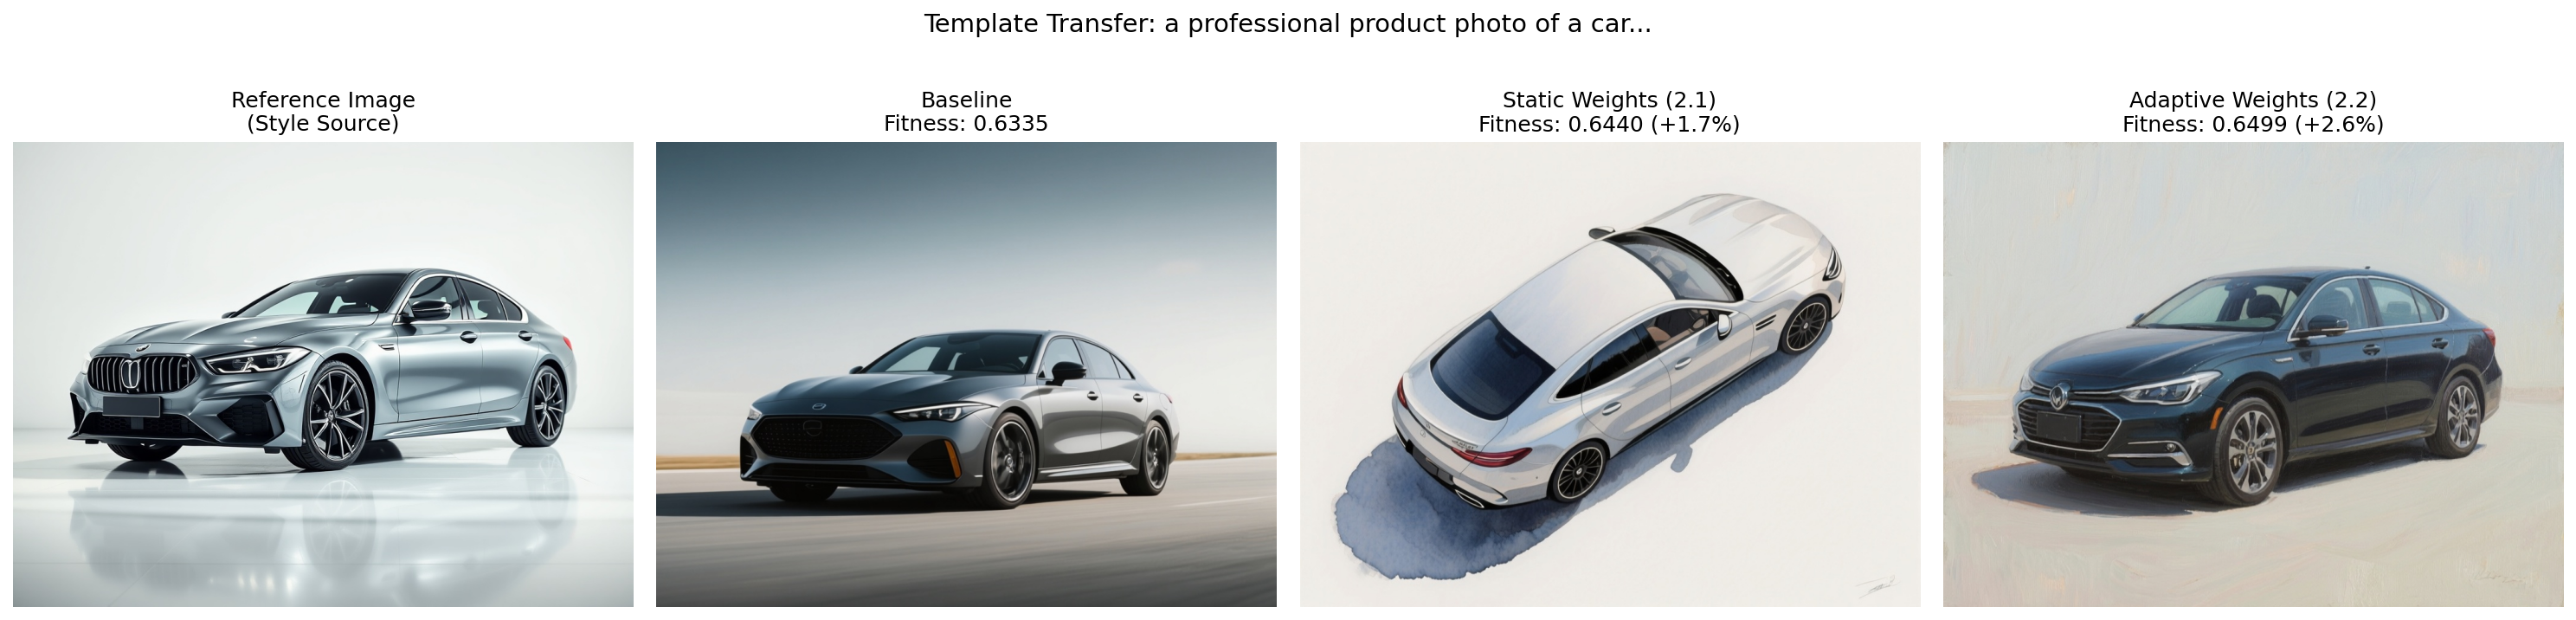


Images saved to output directory.


In [20]:
# Create comprehensive visual comparison: Reference + Baseline + Static + Adaptive
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Reference
axes[0].imshow(reference_image)
axes[0].set_title("Reference Image\n(Style Source)", fontsize=12)
axes[0].axis('off')

# Baseline
axes[1].imshow(baseline_final_image)
axes[1].set_title(f"Baseline\nFitness: {baseline_final_score:.4f}", fontsize=12)
axes[1].axis('off')

# Static best
axes[2].imshow(static_final_image)
improvement_static = (static_final_score - baseline_final_score) / baseline_final_score * 100
axes[2].set_title(f"Static Weights (2.1)\nFitness: {static_final_score:.4f} (+{improvement_static:.1f}%)", fontsize=12)
axes[2].axis('off')

# Adaptive best
axes[3].imshow(adaptive_final_image)
improvement_adaptive = (adaptive_final_score - baseline_final_score) / baseline_final_score * 100
axes[3].set_title(f"Adaptive Weights (2.2)\nFitness: {adaptive_final_score:.4f} (+{improvement_adaptive:.1f}%)", fontsize=12)
axes[3].axis('off')

plt.suptitle(f"Template Transfer: {USER_SUBJECT[:40]}...", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "visual_comparison.png", bbox_inches='tight')
plt.show()

# Save individual images
baseline_final_image.save(OUTPUT_DIR / "final_baseline.jpg")
static_final_image.save(OUTPUT_DIR / "final_static_best.jpg")
adaptive_final_image.save(OUTPUT_DIR / "final_adaptive_best.jpg")

print("\nImages saved to output directory.")

In [21]:
# Print evolved prompts for comparison
print("=" * 60)
print("EVOLVED PROMPTS COMPARISON")
print("=" * 60)

print(f"\nBASELINE PROMPT:")
print(f"  Positive: {USER_SUBJECT}")
print(f"  Negative: (none)")

print(f"\nSTATIC WEIGHTS BEST PROMPT:")
print(f"  Full: {best_static_genome.to_prompt()}")
print(f"  Negative: {best_static_genome.get_negative_prompt()}")
print(f"  Blocks:")
print(f"    Composition: {best_static_genome.composition}")
print(f"    Lighting: {best_static_genome.lighting}")
print(f"    Style: {best_static_genome.style}")
print(f"    Quality: {best_static_genome.quality}")

print(f"\nADAPTIVE WEIGHTS BEST PROMPT:")
print(f"  Full: {best_adaptive_genome.to_prompt()}")
print(f"  Negative: {best_adaptive_genome.get_negative_prompt()}")
print(f"  Blocks:")
print(f"    Composition: {best_adaptive_genome.composition}")
print(f"    Lighting: {best_adaptive_genome.lighting}")
print(f"    Style: {best_adaptive_genome.style}")
print(f"    Quality: {best_adaptive_genome.quality}")

EVOLVED PROMPTS COMPARISON

BASELINE PROMPT:
  Positive: a professional product photo of a car
  Negative: (none)

STATIC WEIGHTS BEST PROMPT:
  Full: a professional product photo of a car, macro, bird's eye view, full body, watercolor, minimalist, digital art, masterpiece, best quality, high resolution
  Negative: watermark, overexposed
  Blocks:
    Composition: ['macro', "bird's eye view", 'full body']
    Lighting: []
    Style: ['watercolor', 'minimalist', 'digital art']
    Quality: ['masterpiece', 'best quality', 'high resolution']

ADAPTIVE WEIGHTS BEST PROMPT:
  Full: a professional product photo of a car, full body, photorealistic, oil painting
  Negative: 
  Blocks:
    Composition: ['full body']
    Lighting: []
    Style: ['photorealistic', 'oil painting']
    Quality: []


## Cell 11: Export Results for IEEE Paper

In [22]:
# Compile all results for IEEE paper
print("Compiling results for IEEE paper export...")

# Convert numpy types to Python native types for JSON serialization
def to_native(obj):
    """Convert numpy types to native Python types for JSON serialization."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, dict):
        return {k: to_native(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [to_native(v) for v in obj]
    return obj

# Prepare results dictionary
results = {
    "metadata": {
        "experiment": "2_template_transfer",
        "timestamp": datetime.now().isoformat(),
        "random_seed": RANDOM_SEED,
        "model": MODEL_NAME,
        "reference_generated": GENERATE_REFERENCE,
        "llm_seeding": USE_LLM_SEEDING
    },
    "configuration": {
        "user_subject": USER_SUBJECT,
        "reference_prompt": REFERENCE_PROMPT if GENERATE_REFERENCE else None,
        "population_size": POPULATION_SIZE,
        "max_generations": MAX_GENERATIONS,
        "elite_size": ELITE_SIZE,
        "mutation_rate": MUTATION_RATE,
        "max_items_per_block": MAX_ITEMS_PER_BLOCK
    },
    "baseline": {
        "prompt": USER_SUBJECT,
        "fitness": float(baseline_score)
    },
    "static_weights": {
        "clip_weight": STATIC_CLIP_WEIGHT,
        "lpips_weight": STATIC_LPIPS_WEIGHT,
        "final_best_fitness": float(max(static_final)),
        "final_avg_fitness": float(np.mean(static_final)),
        "final_std_fitness": float(np.std(static_final)),
        "improvement_percent": float((max(static_final) - baseline_score) / baseline_score * 100),
        "best_prompt": best_static_genome.to_prompt(),
        "best_negative": best_static_genome.get_negative_prompt(),
        "best_blocks": {
            "composition": best_static_genome.composition,
            "lighting": best_static_genome.lighting,
            "style": best_static_genome.style,
            "quality": best_static_genome.quality,
            "negative": best_static_genome.negative
        },
        "convergence_history": to_native({
            'best_fitness': static_history['best_fitness'],
            'avg_fitness': static_history['avg_fitness'],
            'diversity': static_history['diversity']
        })
    },
    "adaptive_weights": {
        "initial_clip_weight": INITIAL_CLIP_WEIGHT,
        "final_clip_weight": FINAL_CLIP_WEIGHT,
        "final_best_fitness": float(max(adaptive_final)),
        "final_avg_fitness": float(np.mean(adaptive_final)),
        "final_std_fitness": float(np.std(adaptive_final)),
        "improvement_percent": float((max(adaptive_final) - baseline_score) / baseline_score * 100),
        "best_prompt": best_adaptive_genome.to_prompt(),
        "best_negative": best_adaptive_genome.get_negative_prompt(),
        "best_blocks": {
            "composition": best_adaptive_genome.composition,
            "lighting": best_adaptive_genome.lighting,
            "style": best_adaptive_genome.style,
            "quality": best_adaptive_genome.quality,
            "negative": best_adaptive_genome.negative
        },
        "convergence_history": to_native({
            'best_fitness': adaptive_history['best_fitness'],
            'avg_fitness': adaptive_history['avg_fitness'],
            'diversity': adaptive_history['diversity']
        })
    },
    "statistical_tests": {
        "t_test": {
            "t_statistic": float(t_stat),
            "p_value": float(p_value),
            "significant": bool(p_value < 0.05)
        },
        "mann_whitney_u": {
            "u_statistic": float(u_stat),
            "p_value": float(u_pvalue),
            "significant": bool(u_pvalue < 0.05)
        },
        "effect_size": {
            "cohens_d": float(cohens_d),
            "interpretation": effect_interpretation
        }
    },
    "comparison_summary": {
        "winner": "adaptive" if np.mean(adaptive_final) > np.mean(static_final) else "static",
        "static_mean": float(np.mean(static_final)),
        "adaptive_mean": float(np.mean(adaptive_final)),
        "difference": float(np.mean(adaptive_final) - np.mean(static_final)),
        "relative_improvement": float((np.mean(adaptive_final) - np.mean(static_final)) / np.mean(static_final) * 100) if np.mean(static_final) > 0 else 0
    }
}

# Save to JSON
results_path = OUTPUT_DIR / "results_experiment_2.json"
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to: {results_path}")

# Print summary for paper
print("\n" + "=" * 60)
print("SUMMARY FOR IEEE PAPER")
print("=" * 60)

print(f"\n1. BASELINE PERFORMANCE")
print(f"   - Fitness: {baseline_score:.4f}")

print(f"\n2. EXPERIMENT 2.1 (STATIC WEIGHTS)")
print(f"   - Best Fitness: {max(static_final):.4f}")
print(f"   - Mean Fitness: {np.mean(static_final):.4f} (+/- {np.std(static_final):.4f})")
print(f"   - Improvement: +{(max(static_final) - baseline_score) / baseline_score * 100:.2f}%")

print(f"\n3. EXPERIMENT 2.2 (ADAPTIVE WEIGHTS)")
print(f"   - Best Fitness: {max(adaptive_final):.4f}")
print(f"   - Mean Fitness: {np.mean(adaptive_final):.4f} (+/- {np.std(adaptive_final):.4f})")
print(f"   - Improvement: +{(max(adaptive_final) - baseline_score) / baseline_score * 100:.2f}%")

print(f"\n4. STATISTICAL SIGNIFICANCE")
print(f"   - t-test p-value: {p_value:.4f} ({'significant' if p_value < 0.05 else 'not significant'})")
print(f"   - Cohen's d: {cohens_d:.4f} ({effect_interpretation} effect)")

winner = "Adaptive" if np.mean(adaptive_final) > np.mean(static_final) else "Static"
print(f"\n5. CONCLUSION")
print(f"   - Better approach: {winner} Weights")
print(f"   - Difference in mean fitness: {abs(np.mean(adaptive_final) - np.mean(static_final)):.4f}")

Compiling results for IEEE paper export...
Results saved to: ../data/results/experiment_2/results_experiment_2.json

SUMMARY FOR IEEE PAPER

1. BASELINE PERFORMANCE
   - Fitness: 0.6300

2. EXPERIMENT 2.1 (STATIC WEIGHTS)
   - Best Fitness: 0.6343
   - Mean Fitness: 0.6222 (+/- 0.0094)
   - Improvement: +0.68%

3. EXPERIMENT 2.2 (ADAPTIVE WEIGHTS)
   - Best Fitness: 0.6331
   - Mean Fitness: 0.6199 (+/- 0.0078)
   - Improvement: +0.49%

4. STATISTICAL SIGNIFICANCE
   - t-test p-value: 0.5908 (not significant)
   - Cohen's d: -0.2581 (small effect)

5. CONCLUSION
   - Better approach: Static Weights
   - Difference in mean fitness: 0.0022


In [ ]:
# Generate LaTeX table for paper
print("\n" + "=" * 60)
print("LaTeX TABLE FOR IEEE PAPER")
print("=" * 60)

latex_table = r"""
\begin{table}[htbp]
\centering
\caption{Experiment 2: Template Transfer Results}
\label{tab:exp2_results}
\begin{tabular}{lccc}
\hline
\textbf{Metric} & \textbf{Baseline} & \textbf{Static} & \textbf{Adaptive} \\
\hline
Best Fitness & %.4f & %.4f & %.4f \\
Mean Fitness & - & %.4f & %.4f \\
Std Dev & - & %.4f & %.4f \\
Improvement (\%%) & - & +%.2f\%% & +%.2f\%% \\
\hline
\multicolumn{4}{l}{\textit{Fitness: %.1f\%% CLIP + %.1f\%% LPIPS (Static)}} \\
\multicolumn{4}{l}{\textit{Fitness: %.1f\%% $\rightarrow$ %.1f\%% CLIP (Adaptive)}} \\
\multicolumn{4}{l}{\textit{Statistical Test: t=%.4f, p=%.4f}} \\
\multicolumn{4}{l}{\textit{Effect Size: Cohen's d=%.4f (%s)}} \\
\hline
\end{tabular}
\end{table}
""" % (
    baseline_score, max(static_final), max(adaptive_final),
    np.mean(static_final), np.mean(adaptive_final),
    np.std(static_final), np.std(adaptive_final),
    (max(static_final) - baseline_score) / baseline_score * 100,
    (max(adaptive_final) - baseline_score) / baseline_score * 100,
    STATIC_CLIP_WEIGHT * 100, STATIC_LPIPS_WEIGHT * 100,
    INITIAL_CLIP_WEIGHT * 100, FINAL_CLIP_WEIGHT * 100,
    t_stat, p_value, cohens_d, effect_interpretation
)

print(latex_table)

# Save LaTeX table
with open(OUTPUT_DIR / "table_experiment_2.tex", 'w') as f:
    f.write(latex_table)

print(f"\nLaTeX table saved to: {OUTPUT_DIR / 'table_experiment_2.tex'}")

In [23]:
# Final summary
print("\n" + "=" * 60)
print("EXPERIMENT 2 COMPLETE")
print("=" * 60)

print(f"\nOutput files saved to: {OUTPUT_DIR}")
print("\nGenerated files:")
for f in sorted(OUTPUT_DIR.glob("*")):
    if f.is_file():
        print(f"  - {f.name}")

print("\nExperiment subdirectories:")
for d in sorted(OUTPUT_DIR.glob("exp*")):
    if d.is_dir():
        print(f"  - {d.name}/")

logger.info("Experiment 2 completed successfully.")
print("\nDone!")

2025-12-30 14:59:44,647 - experiment_2 - INFO - Experiment 2 completed successfully.



EXPERIMENT 2 COMPLETE

Output files saved to: ../data/results/experiment_2

Generated files:
  - baseline_image.jpg
  - boxplot_comparison.png
  - comparison_plot.png
  - exp2_1_convergence.png
  - exp2_2_convergence.png
  - final_adaptive_best.jpg
  - final_baseline.jpg
  - final_static_best.jpg
  - reference_display.png
  - reference_image.jpg
  - reference_vs_baseline.png
  - results_experiment_2.json
  - visual_comparison.png

Experiment subdirectories:
  - exp2_1_static/
  - exp2_2_adaptive/

Done!
